<a href="https://colab.research.google.com/github/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLAMA3 Fine-tuning for text classification using QLORA


### Requirements:
* A GPU with enough memory!

### Installs
* They suggest using latest version of transformers
* Must restart after install because the accelerate package used in the hugging face trainer requires it.

In [1]:
# Install Pytorch
%pip install "torch==2.2.2" tensorboard

# Install Hugging Face libraries
%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 42.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 75.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 188.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 184.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 42.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 104.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 120.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 108.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 105.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 87.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Big Picture Overview of Parameter Efficient Fine Tuning Methods like LoRA and QLoRA Fine Tuning for Sequence Classification

**The Essence of Fine-tuning**
- LLMs are pre-trained on vast amounts of data for broad language understanding.
- Fine-tuning is crucial for specializing in specific domains or tasks, involving adjustments with smaller, relevant datasets.

**Model Fine-tuning with PEFT: Exploring LoRA and QLoRA**
- Traditional fine-tuning is resource-intensive; PEFT (Parameter Efficient Fine-tuning) makes the process faster and less demanding.
- Focus on two PEFT methods: LoRA and QLoRA.

**The Power of PEFT**
- PEFT modifies only a subset of the LLM's parameters, enhancing speed and reducing memory demands, making it suitable for less powerful devices.

**LoRA: Efficiency through Adapters**
- **Low-Rank Adaptation (LoRA):** Injects small trainable adapters into the pre-trained model.
- **Equation:** For a weight matrix $W$, LoRA approximates $W = W_0 + BA$, where $W_0$ is the original weight matrix, and $BA$ represents the low-rank modification through trainable matrices $B$ and $A$.
- Adapters learn task nuances while keeping the majority of the LLM unchanged, minimizing overhead.

**QLoRA: Compression and Speed**
- **Quantized LoRA (QLoRA):** Extends LoRA by quantizing the model’s weights, further reducing size and enhancing speed.
- **Innovations in QLoRA:**
  1. **4-bit Quantization:** Uses a 4-bit data type, NormalFloat (NF4), for optimal weight quantization, drastically reducing memory usage.
  2. **Low-Rank Adapters:** Fine-tuned with 16-bit precision to effectively capture task-specific nuances.
  3. **Double Quantization:** Reduces quantization constants from 32-bit to 8-bit, saving additional memory without accuracy loss.
  4. **Paged Optimizers:** Manages memory efficiently during training, optimizing for large tasks.

**Why PEFT Matters**
- **Rapid Learning:** Speeds up model adaptation.
- **Smaller Footprint:** Eases deployment with reduced model size.
- **Edge-Friendly:** Fits better on devices with limited resources, enhancing accessibility.

**Conclusion**
- PEFT methods like LoRA and QLoRA revolutionize LLM fine-tuning by focusing on efficiency, facilitating faster adaptability, smaller models, and broader device compatibility.




### Fine-tuning for Sentiment Analysis Classification:


#### 1. Text Generation with Sentiment Label as part of text
- **Approach**: Train the model to generate text that naturally appends the sentiment label at the end.
- **Input**: "TSLA slashes model Y prices ======"
- **Output**: "TSLA slashes model Y prices ====== Bearish"
- **Use Case**: This method is useful for applications requiring continuous text output that includes embedded sentiment analysis, such as interactive chatbots or automated content creation tools.


#### 2. Sequence Classification Head
- **Approach**: Add a sequence classification head (linear layer) on top of the LLaMa Model transformer. This setup is similar to GPT-2 and focuses on classifying the sentiment based on the last relevant token in the sequence.
    - **Token Positioning**:
        - **With pad_token_id**: The model identifies and ignores padding tokens, using the last non-padding token for classification.
        - **Without pad_token_id**: It defaults to the last token in each sequence.
        - **inputs_embeds**: If embeddings are directly passed (without input_ids), the model cannot identify padding tokens and takes the last embedding in each sequence as the input for classification.
- **Input**: Specific sentences (e.g., "TSLA slashes Model Y prices").
- **Output**: Direct sentiment classification (e.g., "Bearish").
- **Training Objective**: Minimize cross-entropy loss between the predicted and the actual sentiment labels.

https://huggingface.co/docs/transformers/main/en/model_doc/llama

### Peft Configs
* Bits and bytes config for quantization
* Lora config for lora

### Going to use Hugginface Transformers trainer class: Main componenents
* Hugging face dataset (for train + eval)
* Data collater
* Compute Metrics
* Class weights since we use custom trainer and also custom weighted loss..
* trainingArgs: like # epochs, learning rate, weight decay etc..



### Login to huggingface hub to put your LLama token so we can access Llama 3 7B Param Pre-trained Model

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


###### Imports

In [2]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


### Youtube Video Describing How to get Dataset
* Only really need first 3 mins of video

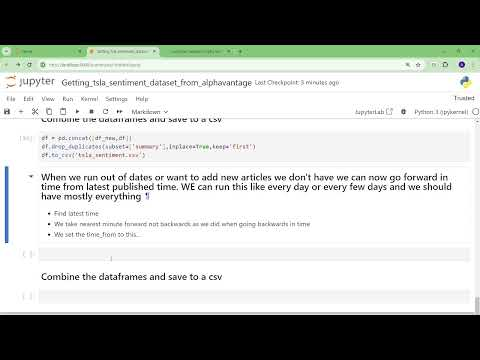

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('ascf3y7zSaY')

#### Load TSLA sentiment analysis dataset
* Derived from Alpha vantage text data...


In [ ]:
df = pd.read_csv("tsla_sentiment.csv")
df

,time_published,summary,label
0,2022-03-05 15:20:00,Tesla's CEO has pushed the automotive sector t...,Bearish
1,2022-03-07 11:50:55,Tesla's market cap soared to over $1 trillion ...,Neutral
2,2022-03-07 14:27:24,"Tesla Inc ( NASDAQ: TSLA ) overcame a ""major...",Neutral
3,2022-03-07 18:11:35,A whale with a lot of money to spend has taken...,Neutral
4,2022-03-07 22:09:00,Tesla and Volkswagen will go head-to-head as b...,Neutral
...,...,...,...
5843,2024-04-08 07:41:27,"In a recent roundtable discussion, China's Min...",Neutral
5844,2024-04-08 07:41:36,"In a recent roundtable discussion, China's Min...",Neutral
5845,2024-04-08 09:02:00,Here's everything you need to know about the e...,Bearish
5846,2024-04-08 11:32:54,Tesla Inc.'s ( TSLA ) shares ended last week d...,Neutral


* Add also a numeric 0,1,2 version of label since we will need it later for fine tuning. We can save it in 'target'

In [ ]:
df['label']=df['label'].astype('category')
df['target']=df['label'].cat.codes

df.head()

,time_published,summary,label,target
0,2022-03-05 15:20:00,Tesla's CEO has pushed the automotive sector t...,Bearish,0
1,2022-03-07 11:50:55,Tesla's market cap soared to over $1 trillion ...,Neutral,2
2,2022-03-07 14:27:24,"Tesla Inc ( NASDAQ: TSLA ) overcame a ""major...",Neutral,2
3,2022-03-07 18:11:35,A whale with a lot of money to spend has taken...,Neutral,2
4,2022-03-07 22:09:00,Tesla and Volkswagen will go head-to-head as b...,Neutral,2


* Suppose you want to decode later

In [ ]:
df['label'].cat.categories

Index(['Bearish', 'Bullish', 'Neutral'], dtype='object')

In [ ]:
category_map = {code: category for code, category in enumerate(df['label'].cat.categories)}
category_map

{0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

### Split into train/val/test for later comparison.
* For simplicity we split based on time.
  - First 60% train
  - Next 20% val
  - Next 20% test
* This can be problematic a bit since class balance changes over time and some articles on boundries between train/val or val/test have some overlap, but completely beats bias of stratified sample usually used since some articles are literally on same thing, but maybe different sources.


In [ ]:
train_end_point = int(df.shape[0]*0.6)
val_end_point = int(df.shape[0]*0.8)
df_train = df.iloc[:train_end_point,:]
df_val = df.iloc[train_end_point:val_end_point,:]
df_test = df.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)



(3508, 4) (1170, 4) (1170, 4)


### Convert from Pandas DataFrame to Hugging Face Dataset
* Also let's shuffle the training set.
* We put the components train,val,test into a DatasetDict so we can access them later with HF trainer.
* Later we will add a tokenized dataset


In [ ]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('label',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('label',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('label',axis=1))


In [ ]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility


In [ ]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['time_published', 'summary', 'target'],
        num_rows: 3508
    })
    val: Dataset({
        features: ['time_published', 'summary', 'target'],
        num_rows: 1170
    })
    test: Dataset({
        features: ['time_published', 'summary', 'target'],
        num_rows: 1170
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['time_published', 'summary', 'target'],
    num_rows: 3508
})

* Since our classes are not balanced let's calculate class weights based on inverse value counts
* Convert to pytorch tensor since we will need it

In [ ]:
df_train.target.value_counts(normalize=True)

target
2    0.452965
1    0.311003
0    0.236032
Name: proportion, dtype: float64

In [ ]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights


tensor([0.4386, 0.3329, 0.2285])

## Load LLama model with 4 bit quantization as specified in bits and bytes and prepare model for peft training

### Model Name

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B"

#### Quantization Config (for QLORA)

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)


#### Lora Config

In [ ]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

#### Load model
* AutomodelForSequenceClassification
* Num Labels is # of classes


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=3
)

model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


* prepare_model_for_kbit_training() function to preprocess the quantized model for training.

In [ ]:
model = prepare_model_for_kbit_training(model)
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


* get_peft_model prepares a model for training with a PEFT method such as LoRA by wrapping the base model and PEFT configuration with get_peft_model

In [ ]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
        

### Load the tokenizer

#### Since LLAMA3 pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Update some model configs
* Must use .cache = False as below or it crashes from my experience

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

### Loop through dataset to measure performance before training/fitting the model
* Use a batch size 32 to kinda vectorize and to avoid memory errors.

In [ ]:
sentences = df_test.summary.tolist()
sentences[0:2]

['Shares of electric vehicle maker Tesla, Inc. TSLA rose sharply in premarket trading on Monday amid reports that the company would manufacture 25,000-euro EVs in its Giga Berlin plant. Tesla CEO Elon Musk said in a post on Friday that he was on a visit to the German plant, which manufactures Model ...',
 "Tesla is planning to build a new electric car model that will be priced at around $25,000 from its factory near Berlin, Reuters reported Monday, making it the company's cheapest offering that could allow it to compete against budget EV makers from Europe and China."]

In [ ]:
# Convert summaries to a list
sentences = df_test.summary.tolist()

# Define the batch size
batch_size = 32  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(sentences), batch_size):
    # Get the batch of sentences
    batch_sentences = sentences[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])



* Concatenate all outputs into a single tensor

In [ ]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[-2.8119,  3.8437, -2.8101],
        [-2.0066,  4.7778, -2.6566],
        [-3.3350,  3.6622, -2.7265],
        ...,
        [-1.5623,  2.9769,  2.2010],
        [-1.4050,  7.0091, -1.4063],
        [-1.2837,  3.5419, -2.3765]], device='cuda:0')

* argmax to get class prediction

In [ ]:
final_outputs.argmax(axis=1)

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

* Move to CPU so we can use numpy and set prediction colum to it

In [ ]:
df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_test['predictions']

<ipython-input-28-7c1d2547ae19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()


4678    1
4679    1
4680    1
4681    1
4682    1
       ..
5843    1
5844    1
5845    1
5846    1
5847    1
Name: predictions, Length: 1170, dtype: int64

In [ ]:
df_test['predictions'].value_counts()

predictions
1    1040
2     112
0      18
Name: count, dtype: int64

#### Use category map to get back category names

In [ ]:
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
df_test['predictions']

<ipython-input-30-b56fb9d5a919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


4678    Bullish
4679    Bullish
4680    Bullish
4681    Bullish
4682    Bullish
         ...   
5843    Bullish
5844    Bullish
5845    Bullish
5846    Bullish
5847    Bullish
Name: predictions, Length: 1170, dtype: object

### Analyze performance as in intro notebook

In [ ]:
def get_performance_metrics(df_test):
  y_test = df_test.label
  y_pred = df_test.predictions

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [ ]:
get_performance_metrics(df_test)

Confusion Matrix:
[[  3 153  24]
 [  9 400  44]
 [  6 487  44]]

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.17      0.02      0.03       180
     Bullish       0.38      0.88      0.54       453
     Neutral       0.39      0.08      0.14       537

    accuracy                           0.38      1170
   macro avg       0.31      0.33      0.23      1170
weighted avg       0.35      0.38      0.27      1170

Balanced Accuracy Score: 0.32720185315360867
Accuracy Score: 0.382051282051282


# Trainer Components
* model
* tokenizer
* training arguments
* train dataset
* eval dataset
* Data Collater
* Compute Metrics
* class_weights: In our case since we are using a custom trainer so we can use a weighted loss we will subclass trainer and define the custom loss.

#### Create LLAMA tokenized dataset which will house our train/val parts during the training process but after applying tokenization

In [ ]:
MAX_LEN = 512
col_to_delete = ['time_published', 'summary']

def llama_preprocessing_function(examples):
    return tokenizer(examples['summary'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets = tokenized_datasets.rename_column("target", "label")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/3508 [00:00<?, ? examples/s]

Map:   0%|          | 0/1170 [00:00<?, ? examples/s]

Map:   0%|          | 0/1170 [00:00<?, ? examples/s]

## Data Collator
A **data collator** prepares batches of data for training or inference in machine learning, ensuring uniform formatting and adherence to model input requirements. This is especially crucial for variable-sized inputs like text sequences.

### Functions of Data Collator

1. **Padding:** Uniformly pads sequences to the length of the longest sequence using a special token, allowing simultaneous batch processing.
2. **Batching:** Groups individual data points into batches for efficient processing.
3. **Handling Special Tokens:** Adds necessary special tokens to sequences.
4. **Converting to Tensor:** Transforms data into tensors, the required format for machine learning frameworks.

### `DataCollatorWithPadding`

The `DataCollatorWithPadding` specifically manages padding, using a tokenizer to ensure that all sequences are padded to the same length for consistent model input.

- **Syntax:** `collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)`
- **Purpose:** Automatically pads text data to the longest sequence in a batch, crucial for models like BERT or GPT.
- **Tokenizer:** Uses the provided `tokenizer` for sequence processing, respecting model-specific vocabulary and formatting rules.

This collator is commonly used with libraries like Hugging Face's Transformers, facilitating data preprocessing for various NLP models.


In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


# define which metrics to compute for evaluation
* We will use balanced accuracy and accuracy for simplicity

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}



### Define custom trainer with classweights
* We will have a custom loss function that deals with the class weights and have class weights as additional argument in constructor

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


# define training args

In [ ]:
training_args = TrainingArguments(
    output_dir = 'sentiment_classification',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 2,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

#### Define custom trainer

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

<ipython-input-36-1bea759fa04e>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


* https://huggingface.co/docs/transformers/en/training

### Run trainer!

In [ ]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,No log,0.945024,0.502258,0.539316
2,1.049700,0.975107,0.507646,0.546154


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


#### Let's check the results
* I wrapped in a function

In [ ]:
def make_predictions(model,df_test):


  # Convert summaries to a list
  sentences = df_test.summary.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(sentences), batch_size):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_test)

In [ ]:
def make_predictions(model,df_test):


  # Convert summaries to a list
  sentences = df_test.summary.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(sentences), batch_size):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_test)

<ipython-input-41-0a3ae9ffca54>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
<ipython-input-41-0a3ae9ffca54>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


In [ ]:
get_performance_metrics(df_test)

Confusion Matrix:
[[119  20  41]
 [ 71 278 104]
 [202 189 146]]

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.30      0.66      0.42       180
     Bullish       0.57      0.61      0.59       453
     Neutral       0.50      0.27      0.35       537

    accuracy                           0.46      1170
   macro avg       0.46      0.52      0.45      1170
weighted avg       0.50      0.46      0.45      1170

Balanced Accuracy Score: 0.5155594882314332
Accuracy Score: 0.4641025641025641


### Saving the model trainer state and model adapters

In [ ]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        2.0
  total_flos               = 22726239GF
  train_loss               =     0.9491
  train_runtime            = 1:02:52.29
  train_samples            =       3508
  train_samples_per_second =       1.86
  train_steps_per_second   =      0.233


#### Saving the adapter model
* Note this doesn't save the entire model. It only saves the adapters.

In [ ]:
trainer.save_model("saved_model")

### Inference from Saved Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r sentiment_classification /content/drive/MyDrive/

In [ ]:
!cp -r saved_model /content/drive/MyDrive/